In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from helper import *

In [2]:
label= "2021-06-25-runs/test_new"
mlabel= "2021-06-25-runs/test_two_0.0_0_99"
gid= "0.0"
pop= "PNs"
N= 800
nglo= N//5
spike_t= np.load(label+"_hom_"+gid+"_"+pop+"_spike_t.npy")
spike_ID= np.load(label+"_hom_"+gid+"_"+pop+"_spike_ID.npy")
mspike_t= np.load(mlabel+"_"+pop+"_spike_t.npy")
mspike_ID= np.load(mlabel+"_"+pop+"_spike_ID.npy")
t_total= spike_t[-1]
mt_total= mspike_t[-1]

In [3]:
def force_aspect(ax,aspect):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [4]:
def glo_avg(sdf: np.ndarray, n):
    nglo= sdf.shape[1]//n
    gsdf= np.zeros((sdf.shape[0],nglo))
    for i in range(nglo):
        gsdf[:,i]= np.mean(sdf[:,n*i:n*(i+1)],axis=1)
    return gsdf

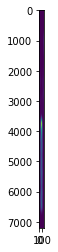

In [25]:
sample_t= 6000
cnum= 24
batch_t= cnum*sample_t
wds= int(t_total//batch_t) # corresponds to number of odours presented / number of batches
li= 0
sigma_sdf= 100
dt_sdf= 1
mxsdfs= np.zeros((wds,cnum))
mnsdfs= np.zeros((wds,cnum))
mxid= np.zeros(wds, dtype=int)
amnsdf=np.zeros((100,24,160))
for i in range(wds):
    meansdf= np.zeros(nglo)
    gsdfs= []
    for j in range(cnum):
        left= i*batch_t+j*sample_t
        right= left+sample_t
        while li < len(spike_t) and spike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(spike_t) and spike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(spike_t[li:ri], spike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs.append(glo_avg(lsdfs,5))
        meansdf+= np.mean(gsdfs[-1][3000:,:],axis=0)
        amnsdf[i,j,:]= np.mean(gsdfs[-1][3000:,:],axis=0)
    mxid[i]= np.argmax(meansdf)  # this is the strongest glomerulus over all concentrations
    for k in range(cnum):
        mxsdfs[i,k]= np.amax(gsdfs[k][:,mxid[i]],axis=0)
        mnsdfs[i,k]= np.mean(gsdfs[k][3000:,mxid[i]],axis=0)

[  1   1   1   1   1  13  31   1   1   1  13   1   1   1  31   1   1   1
   1   1   1   1   1   1   1   1   1  31   1   1   9   1  13   1   1   1
   1   1  41  41  80   1   1   1   1   1   1   1   1   1   1   1  31   1
  13   1   1   1  31   1  13   1   1   1   1   1  13   1   1   1   1   1
   1   1   1  58   1   1  13   1   1   1   1   1   1   1   1   1   1   9
   1   1  13   1   1   1   1   1 116  80]
(100, 160, 2)


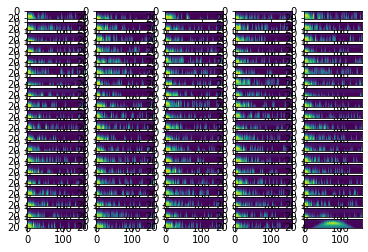

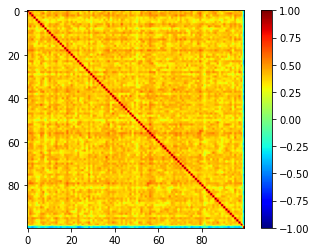

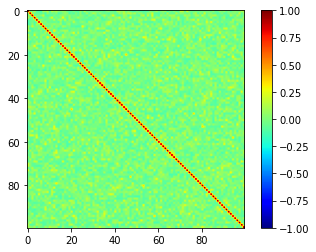

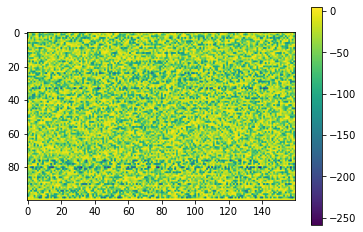

In [42]:
fig, ax= plt.subplots(20,5)
for i in range(20):
    for j in range(5):
        ax[i,j].imshow(np.reshape(amnsdf[i*5+j,:,:],(24,160)))
print(mxid)
cca= np.zeros((100,100))
for i in range(100):
    for j in range(100):
        cc= np.corrcoef(np.reshape(amnsdf[i,-1,:],160),np.reshape(amnsdf[j,-1,:],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1)
plt.colorbar()
#hill= np.load(label+"_hill.npy")
#print(hill)
odors= np.load("2021-07-02-runs/test_new_odors.npy")
print(odors.shape)
for i in range(100):
    for j in range(100):
        cc= np.corrcoef(np.reshape(odors[i,:,0],160),np.reshape(odors[j,:,0],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(np.log(odors[:,:,0]),(100,160)))
plt.colorbar()
#mxo= np.argmax(odors[:,:,1],axis=1)
#print(mxo)
#print(np.amax(odors[0,:,0]))
#print(odors[0,:,0][odors[0,:,0] == np.amax(odors[0,:,0])].shape)

In [6]:
li= 0
mwds= int(mt_total//batch_t) # corresponds to number of odours presented / number of batches
mmxsdfs= np.zeros((mwds,cnum))
mmnsdfs= np.zeros((mwds,cnum))
aimn= np.zeros((mwds,cnum,nglo))
for i in range(mwds):
    for j in range(cnum):
        left= i*batch_t+j*sample_t
        right= left+sample_t
        while li < len(mspike_t) and mspike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(mspike_t) and mspike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(mspike_t[li:ri], mspike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs=glo_avg(lsdfs,5)
        aimn[i,j,:]= np.reshape(np.mean(gsdfs[3000:,:],axis=0),(1,1,-1))
        mmxsdfs[i,j]= np.amax(np.amax(gsdfs))
        mmnsdfs[i,j]= np.amax(np.mean(gsdfs[3000:,:],axis=0))

In [7]:
print(aimn.shape)

(24, 24, 160)


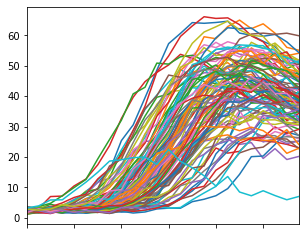

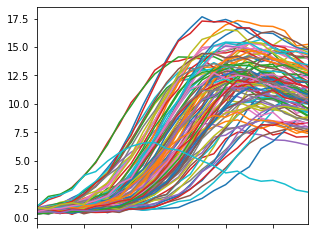

In [8]:
plt.figure()
plt.plot(np.transpose(mxsdfs))
ax= plt.gca()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_xlim((0,23))
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("max_sdfs.png",dpi=300)
plt.figure()
plt.plot(np.transpose(mnsdfs))
ax= plt.gca()
ax.set_xlim((0,23))
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("mean_sdfs.png",dpi=300)

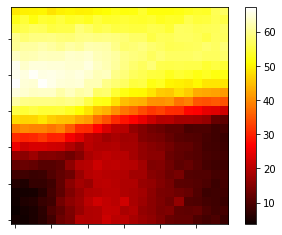

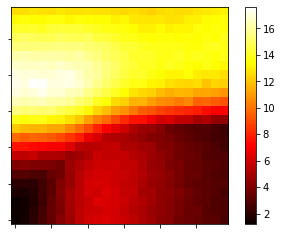

In [9]:
plt.figure()
plt.imshow(mmxsdfs,cmap="hot")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,24,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_max_map.png",dpi=300)
plt.figure()
plt.imshow(mmnsdfs,cmap="hot")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,24,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,24,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_mean_map.png",dpi=300)

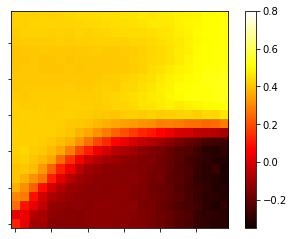

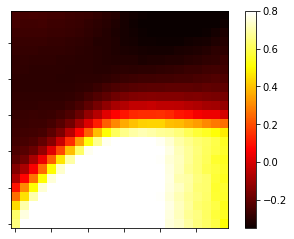

In [10]:
odors= np.load(label+"_odors.npy")
o1= 0
o2= 99
c= np.zeros((cnum,cnum))
for o in [o1, o2]:
    for i in range(cnum):
        for j in range(cnum):
            c[i,j]= np.corrcoef(np.reshape(aimn[i,j,:],-1),np.reshape(odors[o,:,0],-1))[0,1]

    plt.figure()
    plt.imshow(c,cmap="hot",vmin=-0.35, vmax= 0.8)
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax= plt.gca()
    ax.set_xticks(range(0,24,4))
    ax.set_xticklabels([])
    ax.set_yticks(range(0,24,4))
    ax.set_yticklabels([])
    plt.savefig("odor_"+str(o)+"_correl.png", dpi=300)